In [1]:
# Add package root to the path
import sys
from pathlib import Path
path_root = Path().resolve().parents[0]
sys.path.append(str(path_root))
path_root

PosixPath('/Users/daniel/Idan/University/Masters/Thesis/2024/radar_sort')

In [2]:
import argparse
import json
import torch
from torch.utils.data import DataLoader

from utils.paths_collector import Paths
from data.carrada.dataset import Carrada
from evaluation.tester import Tester
from mvrss.utils.functions import count_params
# from mvrss.learners.tester import Tester
from mvrss.models import TMVANet, MVNet
# from mvrss.loaders.dataset import Carrada
from mvrss.loaders.dataloaders import SequenceCarradaDataset

In [3]:
# PARAMETERS
args = {
    'cfg': '/Users/daniel/Idan/University/Masters/Thesis/2024/datasets/logs/carrada/mvnet/mvnet_e300_lr0.0001_s42_0/config.json',
}

target_seq = '2019-09-16-12-55-51' # None for all
frame_num_plot = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
cfg_path = args["cfg"]
with open(cfg_path, 'r') as fp:
    cfg = json.load(fp)

In [5]:
paths = Paths().get()

exp_name = cfg['name_exp'] + '_' + str(cfg['version'])
path = paths['logs'] / cfg['dataset'] / cfg['model'] / exp_name
model_path = path / 'results' / 'model.pt'
test_results_path = path / 'results' / 'test_results.json'

In [6]:
paths

{'warehouse': PosixPath('/Users/daniel/Idan/University/Masters/Thesis/2024/datasets'),
 'logs': PosixPath('/Users/daniel/Idan/University/Masters/Thesis/2024/datasets/logs'),
 'carrada': PosixPath('/Users/daniel/Idan/University/Masters/Thesis/2024/datasets/Carrada'),
 'config': '/Users/daniel/Idan/University/Masters/Thesis/2024/radar_sort/configs/config.ini'}

In [7]:
if cfg['model'] == 'mvnet':
    model = MVNet(n_classes=cfg['nb_classes'], n_frames=cfg['nb_input_channels'])
else:
    model = TMVANet(n_classes=cfg['nb_classes'], n_frames=cfg['nb_input_channels'])
print('Number of trainable parameters in the model: %s' % str(count_params(model)))
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
model = model.to(device)

Number of trainable parameters in the model: 2375432


/var/folders/wh/181dmx3d2v94m8cyv4ny1s_w0000gn/T/ipykernel_49161/729344092.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, m

In [8]:
tester = Tester(cfg)

data = Carrada(config_model=cfg)
test = data.get('Train')

In [9]:
# Select the target sequence if specified
if target_seq is not None:
    test = {target_seq: test[target_seq]}
    
testset = SequenceCarradaDataset(test)
seq_testloader = DataLoader(
    testset,
    batch_size=1,
    shuffle=False, 
    num_workers=0
)

In [10]:
tester.set_annot_type(cfg['annot_type'])

In [11]:
"""
Method to predict on a given dataset using a fixed model

PARAMETERS
----------
net: PyTorch Model
    Network to test
seq_loader: DataLoader
    Specific to the dataset used for test
iteration: int
    Iteration used to display visualization
    Default: None
get_quali: boolean
    If you want to save qualitative results
    Default: False
add_temp: boolean
    Is the data are considered as a sequence
    Default: False
"""
        
# if cfg['model'] == 'mvnet':
#     test_results = tester.predict(model, seq_testloader, get_quali=True, add_temp=False)
# else:
#     test_results = tester.predict(model, seq_testloader, get_quali=True, add_temp=True)

'\nMethod to predict on a given dataset using a fixed model\n\nPARAMETERS\n----------\nnet: PyTorch Model\n    Network to test\nseq_loader: DataLoader\n    Specific to the dataset used for test\niteration: int\n    Iteration used to display visualization\n    Default: None\nget_quali: boolean\n    If you want to save qualitative results\n    Default: False\nadd_temp: boolean\n    Is the data are considered as a sequence\n    Default: False\n'

In [12]:
# tester.write_params(test_results_path)
# test_results_path

# Predict Method Walkthrough
This notebook breaks down the `predict` method of the Tester class step by step

## 1. Imports and Initial Setup
First we need all required imports and configuration

In [13]:
import json
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from mvrss.utils.functions import transform_masks_viz, get_metrics, normalize, define_loss, get_transformations, get_qualitatives
# from mvrss.utils.paths import Paths
from mvrss.utils.metrics import Evaluator
from mvrss.loaders.dataloaders import CarradaDataset

from utils.paths_collector import Paths

In [14]:
net, seq_loader = model, seq_testloader
iteration=None
get_quali=True
add_temp=True

visualizer = None

In [15]:
cfg = cfg
visualizer = visualizer
model = cfg['model']
nb_classes = cfg['nb_classes']
annot_type = cfg['annot_type']
process_signal = cfg['process_signal']
w_size = cfg['w_size']
h_size = cfg['h_size']
n_frames = cfg['nb_input_channels']
batch_size = cfg['batch_size']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
custom_loss = cfg['custom_loss']
transform_names = cfg['transformations'].split(',')
norm_type = cfg['norm_type']
paths = Paths().get()
test_results = dict()
cfg

{'name': 'mvnet',
 'model': 'mvnet',
 'dataset': 'carrada',
 'signal_type': 'mimo',
 'process_signal': True,
 'annot_format': 'light_frame',
 'annot_type': 'dense',
 'w_size': 256,
 'h_size': 256,
 'nb_classes': 4,
 'nb_input_channels': 3,
 'nb_epochs': 300,
 'batch_size': 15,
 'lr': 0.0001,
 'lr_step': 20,
 'loss_step': 100,
 'val_step': 2000,
 'viz_step': 4000,
 'torch_seed': 42,
 'numpy_seed': 42,
 'version': 0,
 'device': 'cuda',
 'custom_loss': 'wce_w10sdice',
 'transformations': 'flip',
 'norm_type': 'tvt',
 'rd_loss_weight': 1,
 'ra_loss_weight': 1,
 'shuffle': True,
 'comments': 'Multi-View network (MV-Net), former H-Net. Methods: data aug (flip) + multi loss + 3 input frames. Model selection: mean of precision. Normalisation: TVT. Loss: wCE + weighted Soft Dice Loss (10*SDice).',
 'name_exp': 'mvnet_e300_lr0.0001_s42'}

## Setup - Preparing the Evaluation Environment
In this cell, we set the network to evaluation mode, create the test-time transformations, initialize loss functions and evaluation metrics, and define some lists to collect running losses. We also set a random sequence index if you are using visualization for a specific iteration.

In [16]:
cfg  # Set the network to evaluation mode
net.eval()

# Prepare transformations for the test split (assumes get_transformations is defined)
transformations = get_transformations(
    transform_names, split='test', sizes=(w_size, h_size))

# Define loss functions for range_doppler and range_angle (assumes define_loss is defined)
rd_criterion = define_loss('range_doppler', custom_loss, device)
ra_criterion = define_loss('range_angle', custom_loss, device)
nb_losses = len(rd_criterion)

# Initialize lists to store running losses and detailed sub-losses
running_losses = []
rd_running_losses = []
rd_running_global_losses = [[], []]  # Two sub-losses for range_doppler
ra_running_losses = []
ra_running_global_losses = [[], []]  # Two sub-losses for range_angle
coherence_running_losses = []

# Initialize evaluators for metrics (assumes Evaluator is defined)
rd_metrics = Evaluator(num_class=nb_classes)
ra_metrics = Evaluator(num_class=nb_classes)

# If an iteration number is provided, choose a random sequence from the loader for visualization
if iteration is not None:
    rand_seq = np.random.randint(len(seq_loader))

## Looping Over Sequences
Here we iterate over the sequences in the seq_loader. For each sequence, we create a frame-level dataloader and prepare for potential visualization if the iteration flag is set.

In [17]:
# Loop over each sequence in the seq_loader
for i, sequence_data in enumerate(seq_loader):
    seq_name, seq = sequence_data
    # Construct the path to the frames (assumes paths is defined with key 'carrada')
    path_to_frames = paths['carrada'] / seq_name[0]
    print(seq)
    # Create a DataLoader for the current sequence frames (assumes CarradaDataset is defined)
    frame_dataloader = DataLoader(
        CarradaDataset(seq, annot_type, path_to_frames, process_signal, n_frames, transformations, add_temp),
        shuffle=False,
        batch_size=batch_size,
        num_workers=4
    )
    
    # If visualization is enabled and we are on the random sequence, choose a random frame index
    if iteration is not None and i == rand_seq:
        rand_frame = np.random.randint(len(frame_dataloader))
    
    # Set qualitative iteration counters (for visualization) if qualitative results are needed
    if get_quali:
        quali_iter_rd = n_frames - 1
        quali_iter_ra = n_frames - 1


[('000000',), ('000001',), ('000002',), ('000003',), ('000004',), ('000005',), ('000006',), ('000007',), ('000008',), ('000009',), ('000010',), ('000011',), ('000012',), ('000013',), ('000014',), ('000015',), ('000016',), ('000017',), ('000018',), ('000019',), ('000020',), ('000021',), ('000022',), ('000023',), ('000024',), ('000025',), ('000026',), ('000027',), ('000028',), ('000029',), ('000030',), ('000031',), ('000032',), ('000033',), ('000034',), ('000035',), ('000036',), ('000037',), ('000038',), ('000039',), ('000040',), ('000041',), ('000042',), ('000043',), ('000044',), ('000045',), ('000046',), ('000047',), ('000048',), ('000049',), ('000050',), ('000051',), ('000052',), ('000053',), ('000054',), ('000055',), ('000056',), ('000057',), ('000058',), ('000059',), ('000060',), ('000061',), ('000062',), ('000063',), ('000064',), ('000065',), ('000066',), ('000067',), ('000068',), ('000069',), ('000070',), ('000071',), ('000072',), ('000073',), ('000074',), ('000075',), ('000076',)

## Processing Each Frame
Within each sequence, we loop over the frames. For each frame we:

-    Load and normalize the data (range-doppler, range-angle, and optionally angle-doppler).

-    Pass the data through the network.
-    Compute the predictions and optionally save qualitative results.
-   Update the evaluation metrics.
-   Compute and store the losses

In [18]:
# Get frame_num_plot from the dataloader
for frame_num, frame in enumerate(frame_dataloader):
    rd_mask = frame['rd_mask'].to(device).float()
    curent_frame = frame_num * len(rd_mask)

    if rd_mask[0][1:].max() > 0.0:
        frame_num_plot -= 1
        print(
            f"frame number: {frame_num}, max value = {rd_mask[0][1:].max()} yeyy")
        if frame_num_plot == 0:
            break

# Retrieve tensors and move them to the device (assumes proper keys exist in frame)
rd_data = frame['rd_matrix'].to(device).float()
ra_data = frame['ra_matrix'].to(device).float()
# Only used if model is 'tmvanet'
ad_data = frame['ad_matrix'].to(device).float()
rd_mask = frame['rd_mask'].to(device).float()
ra_mask = frame['ra_mask'].to(device).float()

# Normalize the inputs (assumes normalize is defined)
rd_data = normalize(rd_data, 'range_doppler', norm_type=norm_type).squeeze()
ra_data = normalize(ra_data, 'range_angle', norm_type=norm_type).squeeze()

frame number: 3, max value = 1.0 yeyy
frame number: 4, max value = 1.0 yeyy
frame number: 5, max value = 1.0 yeyy
frame number: 6, max value = 1.0 yeyy
frame number: 15, max value = 1.0 yeyy


In [19]:
print(f"ra_data shape: {rd_data.shape}")
print(f"ra_data shape: {ra_data.shape}")
# Get the batch size
batch_size = rd_data.shape[0]
print(batch_size)

ra_data shape: torch.Size([15, 3, 256, 64])
ra_data shape: torch.Size([15, 3, 256, 256])
15


In [20]:
rd_mask[0][1:].max()

tensor(1.)

In [21]:
# Forward pass through the network (check if model requires angle_doppler data)
if model == 'tmvanet':
    ad_data = normalize(ad_data, 'angle_doppler', norm_type=norm_type).squeeze()
    rd_outputs, ra_outputs = net(rd_data, ra_data, ad_data)
else:
    rd_outputs, ra_outputs = net(rd_data, ra_data)

# Ensure outputs are on the proper device
rd_outputs = rd_outputs.to(device)
ra_outputs = ra_outputs.to(device)
ra_outputs.shape

torch.Size([15, 4, 256, 256])

# Plotting the Results
Finally, we plot the results using the `plot_results` method. This method takes the collected losses and metrics and generates visualizations to help us understand the model's performance.

In [22]:
import matplotlib.pyplot as plt

In [23]:
rd_pred_masks = torch.argmax(rd_outputs, axis=1)[:5]
ra_pred_masks = torch.argmax(ra_outputs, axis=1)[:5]
rd_gt_masks = torch.argmax(rd_mask, axis=1)[:5]
ra_gt_masks = torch.argmax(ra_mask, axis=1)[:5]
rd_pred_grid = make_grid(transform_masks_viz(rd_pred_masks,
                                                nb_classes))
ra_pred_grid = make_grid(transform_masks_viz(ra_pred_masks,
                                                nb_classes))
rd_gt_grid = make_grid(transform_masks_viz(rd_gt_masks,
                                            nb_classes))
ra_gt_grid = make_grid(transform_masks_viz(ra_gt_masks,
                                            nb_classes))
# visualizer.update_multi_img_masks(rd_pred_grid, rd_gt_grid,
#                                         ra_pred_grid, ra_gt_grid,
#                                         iteration)


print("shapes:")
print(f"rd_mask: {rd_mask.shape}")
print(f"rd_outputs: {rd_outputs.shape}")
print(f"rd_pred_masks: {rd_pred_masks.shape}")
print(f"ra_pred_masks: {ra_pred_masks.shape}")
print(f"rd_gt_masks: {rd_gt_masks.shape}")
print(f"ra_gt_masks: {ra_gt_masks.shape}")
print(f"rd_pred_grid: {rd_pred_grid.shape}")
print(f"ra_pred_grid: {ra_pred_grid.shape}")
print(f"rd_gt_grid: {rd_gt_grid.shape}")
print(f"ra_gt_grid: {ra_gt_grid.shape}")

shapes:
rd_mask: torch.Size([15, 4, 256, 64])
rd_outputs: torch.Size([15, 4, 256, 64])
rd_pred_masks: torch.Size([5, 256, 64])
ra_pred_masks: torch.Size([5, 256, 256])
rd_gt_masks: torch.Size([5, 256, 64])
ra_gt_masks: torch.Size([5, 256, 256])
rd_pred_grid: torch.Size([3, 260, 332])
ra_pred_grid: torch.Size([3, 260, 1292])
rd_gt_grid: torch.Size([3, 260, 332])
ra_gt_grid: torch.Size([3, 260, 1292])


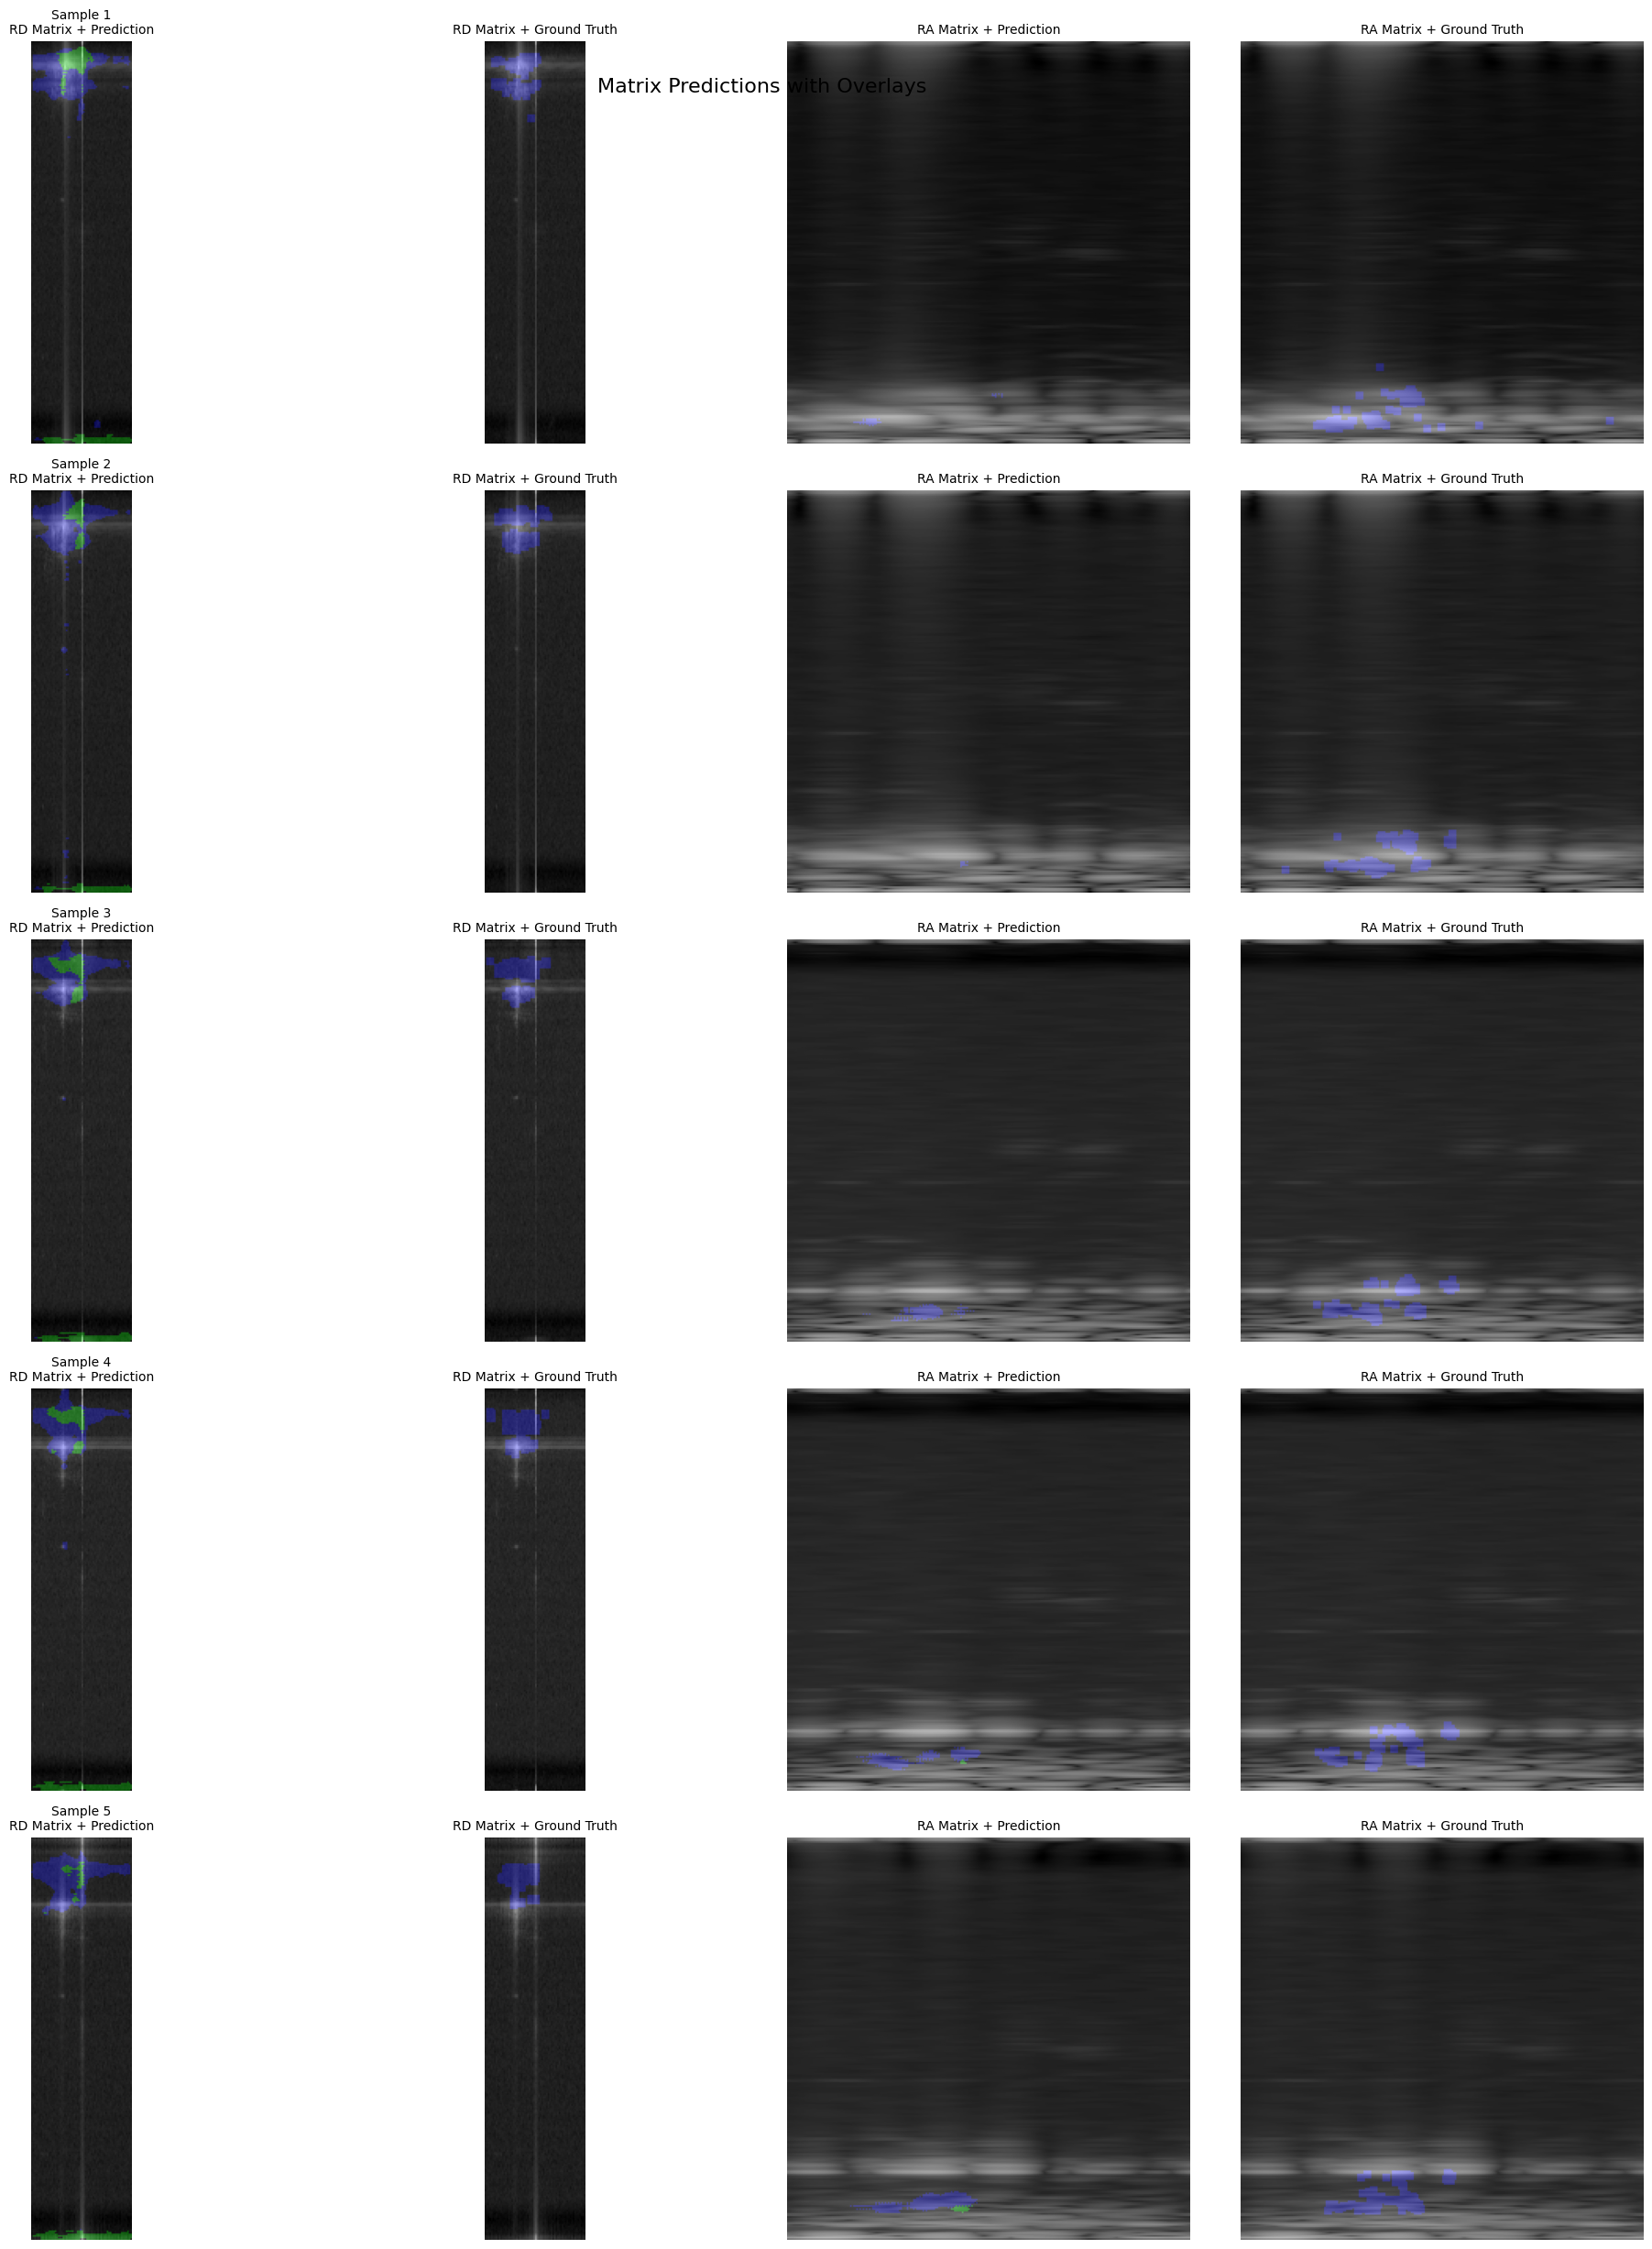

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from mvrss.utils.functions import mask_to_img

# Configuration
batch_size = 5  # Number of predictions
n_classes = 3   # Number of classes
alpha = 0.3     # Transparency for mask overlays

# Create figure with 5 rows (one per prediction) and 4 columns
fig, axs = plt.subplots(batch_size, 4, figsize=(20, 5*batch_size))
fig.suptitle('Matrix Predictions with Overlays', fontsize=16, y=0.95)

for i in range(batch_size):
    # Get corresponding matrix indices (3 matrices per prediction)
    matrix_idx = i * 3

    # --------------------------------------------------
    # RD Column (Left Side)
    # --------------------------------------------------
    # Get final RD matrix in sequence (the one we're predicting)
    rd_matrix = rd_data[matrix_idx+2].cpu().numpy()  # [3, 256, 64]

    # Convert RD matrix to grayscale (average across channels)
    rd_display = rd_matrix.mean(0)  # [256, 64]

    # Get predictions and masks
    rd_pred = rd_pred_masks[i].cpu().numpy()  # [256, 64]
    rd_gt = rd_gt_masks[i].cpu().numpy()      # [256, 64]

    # Convert masks to RGB
    rd_pred_rgb = mask_to_img(rd_pred)
    rd_gt_rgb = mask_to_img(rd_gt)

    # --------------------------------------------------
    # RA Column (Right Side)
    # --------------------------------------------------
    # Get final RA matrix in sequence
    ra_matrix = ra_data[matrix_idx+2].cpu().numpy()  # [3, 256, 256]
    ra_display = ra_matrix.mean(0)  # [256, 256]

    # Get RA predictions
    ra_pred = ra_pred_masks[i].cpu().numpy()  # [256, 256]
    ra_gt = ra_gt_masks[i].cpu().numpy()      # [256, 256]

    # Convert RA masks
    ra_pred_rgb = mask_to_img(ra_pred)
    ra_gt_rgb = mask_to_img(ra_gt)

    # --------------------------------------------------
    # Plotting
    # --------------------------------------------------
    # RD Matrix with Prediction Overlay
    axs[i, 0].imshow(rd_display, cmap='gray')
    axs[i, 0].imshow(rd_pred_rgb, alpha=alpha)
    axs[i, 0].set_title(f'Sample {i+1}\nRD Matrix + Prediction', fontsize=10)
    axs[i, 0].axis('off')

    # RD Matrix with GT Overlay
    axs[i, 1].imshow(rd_display, cmap='gray')
    axs[i, 1].imshow(rd_gt_rgb, alpha=alpha)
    axs[i, 1].set_title('RD Matrix + Ground Truth', fontsize=10)
    axs[i, 1].axis('off')

    # RA Matrix with Prediction Overlay
    axs[i, 2].imshow(ra_display, cmap='gray')
    axs[i, 2].imshow(ra_pred_rgb, alpha=alpha)
    axs[i, 2].set_title('RA Matrix + Prediction', fontsize=10)
    axs[i, 2].axis('off')

    # RA Matrix with GT Overlay
    axs[i, 3].imshow(ra_display, cmap='gray')
    axs[i, 3].imshow(ra_gt_rgb, alpha=alpha)
    axs[i, 3].set_title('RA Matrix + Ground Truth', fontsize=10)
    axs[i, 3].axis('off')

plt.tight_layout()
plt.show()

# NextStop Algorithm: Step-by-Step Breakdown
The NextStop algorithm is designed as an improved tracker for 4D panoptic LiDAR segmentation data, focusing on enhancing temporal consistency and tracking performance, especially for smaller objects like pedestrians and cyclists. It primarily follows a two-stage methodology:

## Stage 1: Bounding Box Tracker

### Object Representation:
 Each detected object in a LiDAR frame is initially represented by a bounding box defined by its centroid position (cx, cy, cz), orientation (θ), dimensions (length, width, height), and a detection score (s).

In [39]:
import torch
import numpy as np
from skimage.measure import label, regionprops 
# Import mpatches for rectangle drawing
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches




def create_bounding_boxes(seg_mask: torch.Tensor | np.ndarray, min_area: int = 0):
    """
    Create bounding boxes from a multi-channel segmentation mask.

    Parameters:
        seg_mask (torch.Tensor): Segmentation mask of shape (n_classes, H, W)
                                 where each channel is a binary mask for that class.
        min_area (int): Minimum area for a region to be considered (filters noise).

    Returns:
        dict: Mapping from class index to a list of bounding boxes.
              Each bounding box is a tuple (min_row, min_col, max_row, max_col).
    """
    if not isinstance(seg_mask, torch.Tensor):
        seg_mask = torch.tensor(seg_mask)

    # Convert to NumPy array if it's on GPU or another torch device
    seg_mask = seg_mask.cpu().numpy() if seg_mask.is_cuda else seg_mask.numpy()

    n_classes, H, W = seg_mask.shape
    bboxes = {}

    for class_idx in range(n_classes):  # Iterate over each class mask
        binary_mask = seg_mask[class_idx] > 0.5  # Thresholding

        # Label connected components
        labeled_mask = label(binary_mask)
        props = regionprops(labeled_mask)

        bboxes[class_idx] = [
            prop.bbox for prop in props if prop.area >= min_area
        ]

    return bboxes

In [63]:
def plot_rd_ra_with_bboxes(rd_matrixx, ra_matrixx, rd_mask, ra_mask, min_area=10):
    """
    Plots RD and RA matrices with segmentation masks and bounding boxes.

    Parameters:
        rd_matrixx (torch.Tensor): RD matrix of shape (T, H, W)
        ra_matrixx (torch.Tensor): RA matrix of shape (T, H, W)
        rd_mask (torch.Tensor): RD segmentation mask of shape (T, C, H, W)
        ra_mask (torch.Tensor): RA segmentation mask of shape (T, C, H, W)
        min_area (int): Minimum area for bounding boxes.
    """
    # Ensure matrices are on CPU and torch.tensors (if its numpy array) for visualization
    rd_matrixx = torch.tensor(rd_matrixx).cpu() if isinstance(rd_matrixx, np.ndarray) else rd_matrixx
    ra_matrixx = torch.tensor(ra_matrixx).cpu() if isinstance(ra_matrixx, np.ndarray) else ra_matrixx
    rd_mask = torch.tensor(rd_mask).cpu() if isinstance(rd_mask, np.ndarray) else rd_mask
    ra_mask = torch.tensor(ra_mask).cpu() if isinstance(ra_mask, np.ndarray) else ra_mask
    
    
    
    # Compute bounding boxes for RD and RA segmentation masks (last frame)
    rd_bboxes = create_bounding_boxes(rd_mask, min_area=min_area)
    ra_bboxes = create_bounding_boxes(ra_mask, min_area=min_area)

    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # RD Matrix subplot
    ax1 = axes[0]
    print(f"rd_matrixx shape innnnn: {ra_matrix.shape}")
    ax1.imshow(rd_matrixx.squeeze(), cmap='viridis')
    ax1.set_title(f'RD Matrix with Bounding Boxes (min_area={min_area})')

    # Overlay RD segmentation mask
    rd_seg_overlay = rd_mask.cpu().numpy().squeeze()
    ax1.imshow(rd_seg_overlay.transpose(1, 2, 0), alpha=0.5, cmap='jet')

    # Draw bounding boxes on RD map
    for class_idx, boxes in rd_bboxes.items():
        for bbox in boxes:
            min_row, min_col, max_row, max_col = bbox
            width, height = max_col - min_col, max_row - min_row
            rect = mpatches.Rectangle(
                (min_col, min_row), width, height, fill=False, color='red', linewidth=2)
            ax1.add_patch(rect)
            ax1.text(min_col, min_row, f'Class {class_idx}', fontsize=10, weight='bold', color='white',
                     bbox=dict(facecolor='black', alpha=0.5))

    # RA Matrix subplot
    ax2 = axes[1]
    print(f"ra_matrix shape innnnn: {ra_matrixx.shape}")
    ax2.imshow(ra_matrixx.squeeze(), cmap='viridis')
    ax2.set_title(f'RA Matrix with Bounding Boxes (min_area={min_area})')

    # Overlay RA segmentation mask
    ra_seg_overlay = ra_mask.cpu().numpy().squeeze()
    ax2.imshow(ra_seg_overlay.transpose(1, 2, 0), alpha=0.5, cmap='jet')

    # Draw bounding boxes on RA map
    for class_idx, boxes in ra_bboxes.items():
        for bbox in boxes:
            min_row, min_col, max_row, max_col = bbox
            width, height = max_col - min_col, max_row - min_row
            rect = mpatches.Rectangle(
                (min_col, min_row), width, height, fill=False, color='red', linewidth=2)
            ax2.add_patch(rect)
            ax2.text(min_col, min_row, f'Class {class_idx}', fontsize=10, weight='bold', color='white',
                     bbox=dict(facecolor='black', alpha=0.5))

    # Show figure
    plt.tight_layout()
    plt.show()

shapes of matrices:
rd_matrix_frame: torch.Size([256, 64])
ra_matrix_frame: torch.Size([256, 256])
rd_mask_frame: torch.Size([3, 256, 64])
ra_mask_frame: torch.Size([3, 256, 256])
rd_outputs_frame: (3, 256, 64)
ra_outputs_frame: (3, 256, 256)
rd_matrixx shape innnnn: (3, 256, 256)
ra_matrix shape innnnn: torch.Size([256, 256])


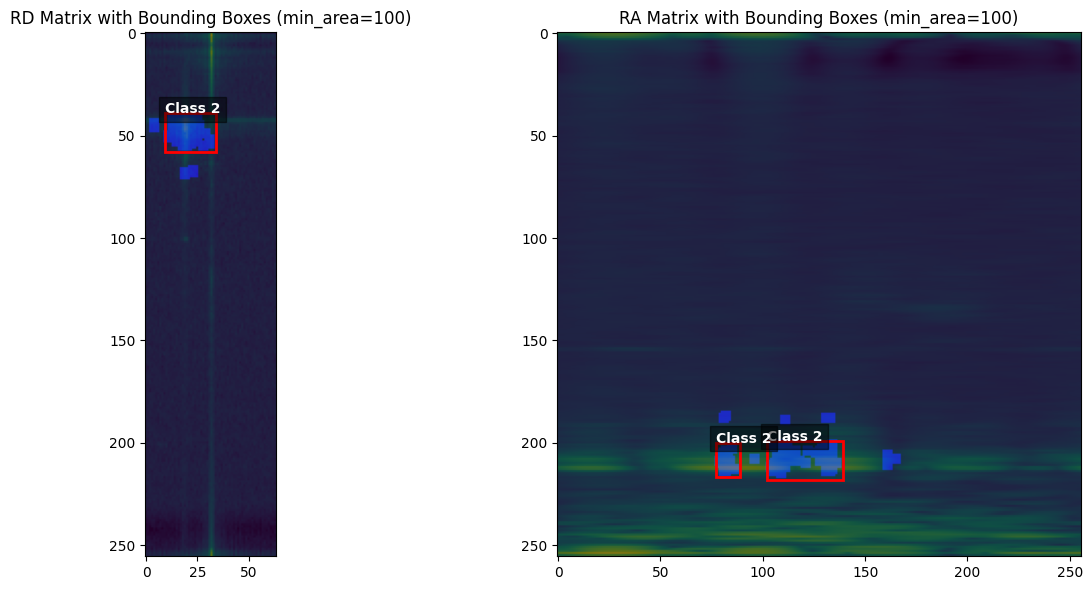

rd_matrixx shape innnnn: (3, 256, 256)
ra_matrix shape innnnn: torch.Size([256, 256])


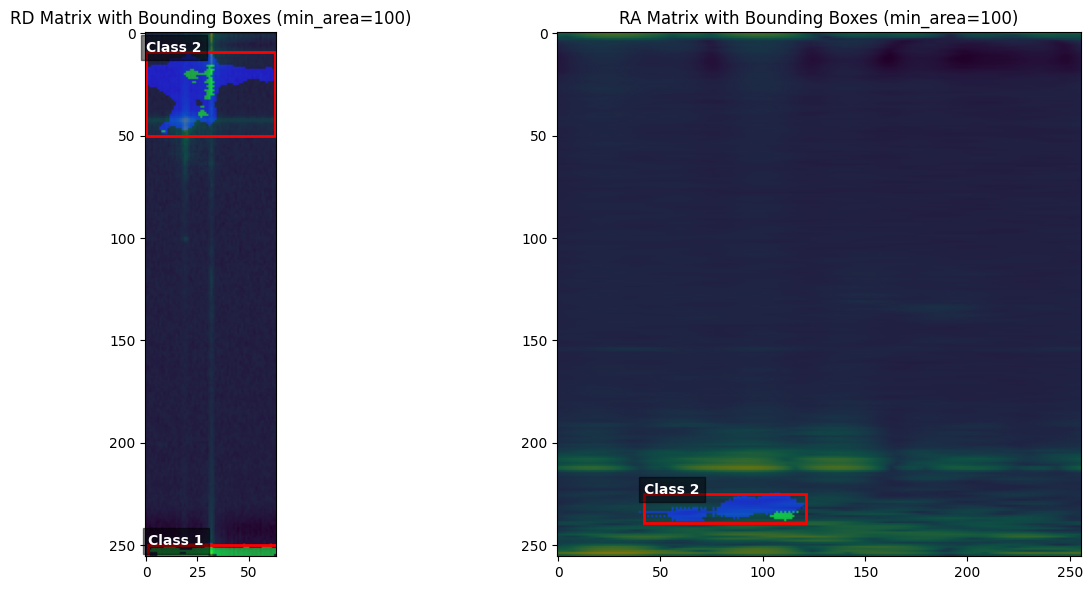

In [67]:
min_area = 100  # Minimum area for bounding boxes
rd_matrix_frame = rd_data[-1].mean(0)
ra_matrix_frame = ra_data[-1].mean(0)
rd_mask_frame = rd_mask[-1][-3:]
ra_mask_frame = ra_mask[-1][-3:]
rd_outputs_frame = np.array(mask_to_img(rd_pred_masks[-1])).transpose(2, 0, 1)
ra_outputs_frame = np.array(mask_to_img(ra_pred_masks[-1])).transpose(2, 0, 1)

print(f"shapes of matrices:")
print(f"rd_matrix_frame: {rd_matrix_frame.shape}")
print(f"ra_matrix_frame: {ra_matrix_frame.shape}")
print(f"rd_mask_frame: {rd_mask_frame.shape}")
print(f"ra_mask_frame: {ra_mask_frame.shape}")
print(f"rd_outputs_frame: {rd_outputs_frame.shape}")
print(f"ra_outputs_frame: {ra_outputs_frame.shape}")

# Plot RD and RA matrices with bounding boxes
plot_rd_ra_with_bboxes(rd_matrix_frame, ra_matrix_frame, rd_mask_frame,
                       ra_mask_frame, min_area=min_area)
plot_rd_ra_with_bboxes(rd_matrix_frame, ra_matrix_frame, rd_outputs_frame,
                       ra_outputs_frame, min_area=min_area)